# CHAT-BOT ANALYSIS

In [1]:
# import libraries here
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Leemos el csv
chatbot=pd.read_csv('chatbot_usuarios.csv', sep=';', header=0,encoding = 'unicode_escape')
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD
0,que significa ux?,usuario 1,15/10/19,18.0
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0
3,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0
4,tengo que saber a programar para hacer el boot...,usuario 5,16/10/19,23.0


In [3]:
chatbot.shape

(72, 4)

In [4]:
# Nos quedamos solo con los 14 usuarios (los demás se repiten)
df_usuarios = chatbot[0:14][['USUARIOS','EDAD']]

In [5]:
# Eliminamos la columna ['EDAD'] para rellenar las edades a continuación;
df_chatbot = chatbot.drop(['EDAD'], axis=1)

In [6]:
# Creamos la nueva versión ['EDAD'] completa
chatbot = pd.merge(df_chatbot, df_usuarios,  how='left', left_on=['USUARIOS'], right_on = ['USUARIOS'])

In [7]:
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD
0,que significa ux?,usuario 1,15/10/19,18.0
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0


In [8]:
# Conocemos la estructura del dataset
chatbot.shape

(87, 4)

In [9]:
# Limpiamos tokenizando y agregando en una columna nueva los datos limpios
from nltk import sent_tokenize, word_tokenize

In [10]:
frases = sent_tokenize(chatbot['PREGUNTAS FRECUENTES'][1])
frases

['me gustaria saber informacion sobre el bootcamp de web que proporciona ironhack']

In [11]:
# Metemos cada frase en una lista tokenizada 
chatbot['PF_PALABRAS']=chatbot['PREGUNTAS FRECUENTES'].apply(word_tokenize)

In [12]:
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS
0,que significa ux?,usuario 1,15/10/19,18.0,"[que, significa, ux, ?]"
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,"[me, gustaria, saber, informacion, sobre, el, ..."
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,"[que, tipo, de, cursos, se, imparten, en, iron..."
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,"[que, tipo, de, cursos, se, imparten, en, iron..."
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,"[como, son, los, prcesos, de, admisionpara, ha..."


In [13]:
# Mediante la construcción de una función, limpiamos la nueva columna

def clean_up(s):
    """
    Cleans up numbers, URLs, and special characters from a string.

    Args:
        s: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    import re
    s = re.sub("http://ironhack.com", ' ', s)
    s = re.sub('\d+', ' ', s)
    s = re.sub('\W+', ' ', s)
    s = s.lower().strip()
    return s

In [14]:
# Aplicamos la función 'clean_up'
chatbot['PF_PALABRAS']=chatbot['PREGUNTAS FRECUENTES'].apply(clean_up)
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...


In [15]:
# Creamos una función para tokenizar las siguientes columnas
def tokenize(s):
    """
    Tokenize a string.

    Args:
        s: String to be tokenized.

    Returns:
        A list of words as the result of tokenization.
    """
    from nltk import word_tokenize
    s = word_tokenize(s)
    return s

In [16]:
# Aplicamos la función 'tokenize'
chatbot['PF_LISTA']=chatbot['PF_PALABRAS'].apply(tokenize)
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[que, significa, ux]"
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[me, gustaria, saber, informacion, sobre, el, ..."
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[que, tipo, de, cursos, se, imparten, en, iron..."
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[que, tipo, de, cursos, se, imparten, en, iron..."
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[como, son, los, prcesos, de, admisionpara, ha..."


In [17]:
# Contamos el número de palabras del PREGUNTAS FRECUENTES.
chatbot['word_count'] = chatbot['PF_LISTA'].apply(len)
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[que, significa, ux]",3
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[me, gustaria, saber, informacion, sobre, el, ...",12
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[que, tipo, de, cursos, se, imparten, en, iron...",8
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[que, tipo, de, cursos, se, imparten, en, iron...",8
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[como, son, los, prcesos, de, admisionpara, ha...",11


In [18]:
# Contamos también el número total de letras .
chatbot['char_len'] = chatbot['PF_LISTA'].apply(lambda comment: sum(len(word) for word in comment))
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[que, significa, ux]",3,14
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[me, gustaria, saber, informacion, sobre, el, ...",12,68
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[que, tipo, de, cursos, se, imparten, en, iron...",8,35
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[que, tipo, de, cursos, se, imparten, en, iron...",8,35
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[como, son, los, prcesos, de, admisionpara, ha...",11,49


In [19]:
# Sacamos el número de stops words que hay en PREGUNTAS FRECUENTES marcando el idioma español.
stop = stopwords.words('spanish')
chatbot['stopwords'] = chatbot['PF_LISTA'].apply(lambda comment: len([word for word in comment if word in stop]))
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len,stopwords
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[que, significa, ux]",3,14,1
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[me, gustaria, saber, informacion, sobre, el, ...",12,68,5
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[que, tipo, de, cursos, se, imparten, en, iron...",8,35,4
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[que, tipo, de, cursos, se, imparten, en, iron...",8,35,4
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[como, son, los, prcesos, de, admisionpara, ha...",11,49,6


In [20]:
stop_words = ['a', 'con', 'de', 'desde', 'en', 'entre', 'hasta', 'para', 'por', 'sin', 'sobre', 'tras', 'via', 'me', 'mi', 'te', 'el', 'la','el', 'que','tipo','puedo','puede','ser']

for pregunta in chatbot['PF_LISTA']:
    for word in pregunta:
        if word in stop: pregunta.remove(word)
        elif word in stop_words: pregunta.remove(word)
            

In [21]:
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len,stopwords
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[significa, ux]",3,14,1
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[gustaria, saber, informacion, el, bootcamp, w...",12,68,5
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[son, prcesos, admisionpara, hacer, curso, data]",11,49,6


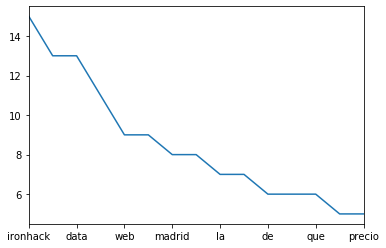

In [22]:
# Buscamos las palabras más frecuentes.
freq = pd.Series(' '.join(" ".join(comment) for comment in chatbot['PF_LISTA']).split(" ")).value_counts()[:15]
freq.plot()

In [24]:
# Buscamos las palabras menos frecuentes.
less_freq = pd.Series(' '.join(" ".join(comment) for comment in chatbot['PF_LISTA']).split(" ")).value_counts()[-10:]
less_freq

ir              1
preguntar       1
impartir        1
puedes          1
parones         1
admisionpara    1
bootcamop       1
ayudar          1
manera          1
muy             1
dtype: int64

In [25]:
# Eliminamos las palabras menos frecuentes.
less_freq_list = list(less_freq.index)
chatbot['PF_LISTA'] = chatbot['PF_LISTA'].apply(lambda comment: [word for word in comment if word not in less_freq_list])
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len,stopwords
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[significa, ux]",3,14,1
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[gustaria, saber, informacion, el, bootcamp, w...",12,68,5
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[son, prcesos, hacer, curso, data]",11,49,6


In [26]:
#Descargamos el CSV con nuestro Data Frame.
#chatbot.to_csv('chatbot_analysis.csv')

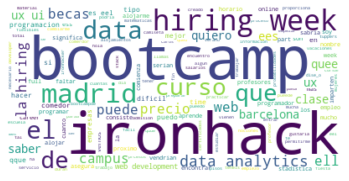

In [27]:
# Creamos y descargamos una nube de palabras para poder analizar cuáles son las palabras más utilizadas.

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

wordcloud = WordCloud(max_font_size=70, background_color="White").generate(" ".join(" ".join(comment) for comment in chatbot['PF_LISTA']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")


plt.savefig('nube.png')
plt.show()

In [28]:
# Creamos una lista con las palabras clave que queremos analizar

keywords=['data','web','ux']

def key_words(x):
    new_list=[]
    for word in x:
        if word in keywords:
            new_list.append(word)
    return new_list

In [29]:
# Añadimos la lista con las palabras clave
chatbot['KEY_WORDS']=chatbot['PF_LISTA'].apply(key_words)
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len,stopwords,KEY_WORDS
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[significa, ux]",3,14,1,[ux]
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[gustaria, saber, informacion, el, bootcamp, w...",12,68,5,[web]
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[]
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[]
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[son, prcesos, hacer, curso, data]",11,49,6,[data]


In [30]:
# Sacamos la lista donde aparecen las key words
chatbot['KEY_WORDS'].head()

0      [ux]
1     [web]
2        []
3        []
4    [data]
Name: KEY_WORDS, dtype: object

In [31]:
# Mediante una función, pasamos la columna de 'KEY_WORDS' a strings, para su posterior análisis
def key_words_string(x):
    lista = []
    for word in x:
        if word in keywords:
            return word

In [32]:
# Aplicamos la función 'key_words_string'
chatbot['KEY_WORDS_STR']=chatbot['PF_LISTA'].apply(key_words_string)
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len,stopwords,KEY_WORDS,KEY_WORDS_STR
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[significa, ux]",3,14,1,[ux],ux
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[gustaria, saber, informacion, el, bootcamp, w...",12,68,5,[web],web
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[],None
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[],None
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[son, prcesos, hacer, curso, data]",11,49,6,[data],data


In [33]:
chatbot['key_count'] = np.where(chatbot['KEY_WORDS_STR'].isin(keywords), 1,0)
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len,stopwords,KEY_WORDS,KEY_WORDS_STR,key_count
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[significa, ux]",3,14,1,[ux],ux,1
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[gustaria, saber, informacion, el, bootcamp, w...",12,68,5,[web],web,1
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[],None,0
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[],None,0
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[son, prcesos, hacer, curso, data]",11,49,6,[data],data,1


In [34]:

chatbot['KEY_WORDS_STR'] = chatbot['KEY_WORDS_STR'].fillna('Nada')
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len,stopwords,KEY_WORDS,KEY_WORDS_STR,key_count
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[significa, ux]",3,14,1,[ux],ux,1
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[gustaria, saber, informacion, el, bootcamp, w...",12,68,5,[web],web,1
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[],Nada,0
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[],Nada,0
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[son, prcesos, hacer, curso, data]",11,49,6,[data],data,1


In [35]:
# Resultado de qué bootcamp se pregunta más 
sum_keywords = chatbot['KEY_WORDS_STR'].value_counts()
sum_keywords

Nada    57
data    13
web      9
ux       8
Name: KEY_WORDS_STR, dtype: int64

In [64]:
menor_edad = chatbot['EDAD'].min()
menor_edad

18.0

In [39]:
mayor_edad = chatbot['EDAD'].max()
mayor_edad

35.0

In [40]:
mean_edad = chatbot['EDAD'].mean()
mean_edad

24.529411764705884

In [41]:
# Sacamos el número de personas por edad
sum_edad = chatbot['EDAD'].value_counts()
sum_edad

24.0    20
22.0    17
27.0    15
35.0     9
23.0     9
18.0     8
21.0     5
29.0     1
26.0     1
Name: EDAD, dtype: int64

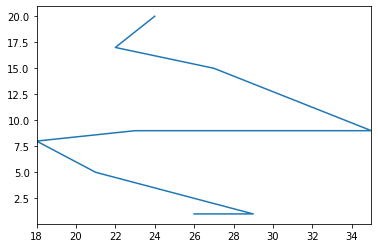

In [42]:
sum_edad.plot()

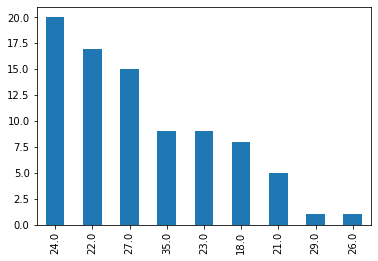

In [43]:
# Gráfica que repesenta la cantidad de personas por edades
chatbot['EDAD'].value_counts().plot(kind='bar')

In [44]:
chatbot.head()

,PREGUNTAS FRECUENTES,USUARIOS,FECHA,EDAD,PF_PALABRAS,PF_LISTA,word_count,char_len,stopwords,KEY_WORDS,KEY_WORDS_STR,key_count
0,que significa ux?,usuario 1,15/10/19,18.0,que significa ux,"[significa, ux]",3,14,1,[ux],ux,1
1,me gustaria saber informacion sobre el bootcam...,usuario 2,15/10/19,22.0,me gustaria saber informacion sobre el bootcam...,"[gustaria, saber, informacion, el, bootcamp, w...",12,68,5,[web],web,1
2,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,22.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[],Nada,0
3,que tipo de cursos se imparten en ironhack?,usuario 3,15/10/19,24.0,que tipo de cursos se imparten en ironhack,"[tipo, cursos, imparten, ironhack]",8,35,4,[],Nada,0
4,como son los prcesos de admisionpara hacer el ...,usuario 4,16/10/19,23.0,como son los prcesos de admisionpara hacer el ...,"[son, prcesos, hacer, curso, data]",11,49,6,[data],data,1


In [45]:
# Sacamos por cada usuario cuantas key words han mencionado
total_data = chatbot.groupby('USUARIOS').agg({'key_count' : 'sum',})
total_data

,key_count
USUARIOS,
usuario 1,6
usuario 10,5
usuario 11,1
usuario 12,0
usuario 13,1
usuario 14,5
usuario 17,0
usuario 2,1
usuario 3,8


In [46]:
# Sacamos por cada usuario cuantas key words han mencionado
key_count_df = chatbot.groupby('KEY_WORDS_STR').agg({'key_count' : 'sum',})
key_count_df

,key_count
KEY_WORDS_STR,
Nada,0
data,13
ux,8
web,9


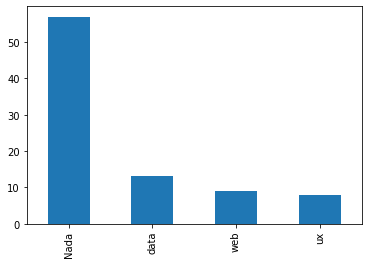

In [47]:
chatbot['KEY_WORDS_STR'].value_counts().plot(kind='bar')

In [48]:
usuario_key_count = chatbot.pivot_table(chatbot,index=['USUARIOS','KEY_WORDS_STR'], aggfunc='count')
usuario_key_count['KEY_WORDS']

USUARIOS    KEY_WORDS_STR
usuario 1   Nada              2
            data              4
            ux                2
usuario 10  Nada              8
            data              2
            ux                2
            web               1
usuario 11  Nada              1
            data              1
usuario 12  Nada              1
usuario 13  Nada              4
            data              1
usuario 14  Nada              4
            ux                4
            web               1
usuario 17  Nada              1
usuario 2   web               1
usuario 3   Nada             22
            data              4
            web               4
usuario 4   Nada              3
            data              1
usuario 5   Nada              4
            web               1
usuario 6   Nada              1
usuario 7   Nada              4
            web               1
usuario 8   Nada              1
usuario 9   Nada              1
Name: KEY_WORDS, dtype: int64

In [49]:
usuario_key_word = usuario_key_count['KEY_WORDS'].reset_index()
usuario_key_word

,USUARIOS,KEY_WORDS_STR,KEY_WORDS
0,usuario 1,Nada,2
1,usuario 1,data,4
2,usuario 1,ux,2
3,usuario 10,Nada,8
4,usuario 10,data,2
5,usuario 10,ux,2
6,usuario 10,web,1
7,usuario 11,Nada,1
8,usuario 11,data,1
9,usuario 12,Nada,1


In [50]:
ukw = pd.DataFrame(usuario_key_word)
ukw.head()

,USUARIOS,KEY_WORDS_STR,KEY_WORDS
0,usuario 1,Nada,2
1,usuario 1,data,4
2,usuario 1,ux,2
3,usuario 10,Nada,8
4,usuario 10,data,2


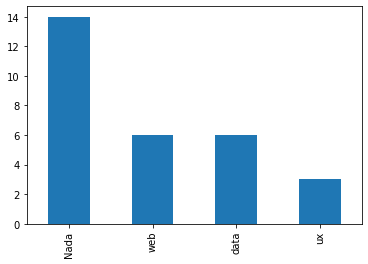

In [51]:
ukw['KEY_WORDS_STR'].value_counts().plot(kind='bar')

In [56]:
# Analizamos
chatbot.shape

(87, 12)

In [57]:
encoding1 = pd.get_dummies(chatbot['KEY_WORDS_STR'])
encoding1.head()

,Nada,data,ux,web
0,0,0,1,0
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0


In [58]:
# one hot encoding
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [59]:
data = [word for word in chatbot['KEY_WORDS_STR']]
data = chatbot['KEY_WORDS_STR']

values = array(data)
print(values)

['ux' 'web' 'Nada' 'Nada' 'data' 'web' 'Nada' 'Nada' 'web' 'Nada' 'Nada'
 'Nada' 'data' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada'
 'Nada' 'Nada' 'Nada' 'ux' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada'
 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada'
 'Nada' 'Nada' 'Nada' 'web' 'web' 'data' 'Nada' 'data' 'Nada' 'Nada'
 'Nada' 'Nada' 'ux' 'ux' 'ux' 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'data'
 'Nada' 'Nada' 'Nada' 'Nada' 'Nada' 'data' 'web' 'ux' 'Nada' 'data' 'data'
 'ux' 'web' 'web' 'web' 'data' 'data' 'data' 'Nada' 'Nada' 'data' 'data'
 'Nada' 'Nada' 'ux']


In [60]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

[2 3 0 0 1 3 0 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 3 1 0 1 0 0 0 0 2 2 2 0 0 0 0 0 1 0 0 0 0 0 1 3 2 0 1 1 2
 3 3 3 1 1 1 0 0 1 1 0 0 2]


In [61]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [62]:
df1 = pd.DataFrame(onehot_encoded)
df1.head()

,0,1,2,3
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0
